In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from pathlib import Path
import os
import sys

import joblib
import json
import pickle

import warnings
warnings.filterwarnings('ignore')

### 1) Loading the Contract Data
    - Display the first 10 rows of the dataframe
    - Pull data with the Cancel_Model_data.sql

SQL query used in analysis

In [2]:
sql_1 = """    
select 
	Contract_Number
	,Contract_Id
	,Sales_Channel
	,Insurance_Type
	,Insurer_Code
	,Product_type_desc
	,Coverage_Group
	,Deductible
	,Deductible_Type
	,Sale_Date
	,Effective_Date
	,DATEDIFF(MONTH, Effective_Date, GETDATE()) AS Duration
	,In_Service_Date
	,OEMExpireDate
	,Inserted_Date
	,Active_Date
	,Expiration_Date
	,Cancel_Effect_Date
	,Coverage_Termination_Date
	,Term_Months
	,Term_Mileage
	,Customer_State
	,New_Used
	,GPW_NUP
	,Make
	,Model
	,Model_Year
	,YEAR(GETDATE()) - Model_Year AS Vehicle_Age
	,Vehicle_Class
	,Sale_Odometer
	,Effective_Odometer
	,Expire_Odometer
	,Retail_Amount			-- Value of Vehicle
	,Admin_Cost				-- Fee with EWS
	,Dealer_Cost			-- Amount the Dealer
	,[Base Reserve]			-- Base Amount that is reserved
	,[Claim Reserve]		-- Reserve
	,[Insurance Fee]		-- Why is this here??
	,[Admin Fees]
	,[Gray Claim Fee]		-- Idk what this is 
	,Dealer_Number
	,Dealer_Name
	,Dealer_State
	,Dealer_Status
	,CASE 
        WHEN [Status] IN ('Active', 'Expired') THEN 'Not_Cancelled'
        ELSE [Status]
     END AS [Status]
	--,[Status]				-- Target Variable
from risk.monthly_actuarial_review_contract

-- join on the moxy data

where 
	Dealer_Status = 'Active' and
	Sales_Channel = 'Telemarketing'
;

"""

In [2]:
file_path = 'C:\\Users\RaymondGreenfield\\OneDrive - endurancedirect.com\\Documents\\Actuarial_Work\\src\\data\\contract_data_03202025.csv'

df = pd.read_csv(file_path, delimiter=",")

In [3]:
# Show the first 10 rows of the dataframe
df.head(10)

,Contract_Number,Sale_Date,Cancel_Date,Duration,Term,Vehicle_Age,Make,Model,Mileage,New_Used,...,Finance_Term,Policy_Miles,Customer_Cost,Down_Payment,Finance_Payment,Retail_Price,Warranty_Cost,Paid_In_Full,Customer_Monthly_Payment,Status
0,1005299DAS,2011-06-06,NaN,0.0,0.0,22.0,CHEVROLET,SUBURBAN,191978,N,...,12,60000.0,3289.0,195.0,171.89,3289.0,939.0,NaN,NaN,Not_Cancelled
1,83524003419,2012-02-20,NaN,0.0,0.0,18.0,BMW,525,44371,N,...,12,48000.0,3746.0,250.0,0.00,4428.0,2078.0,NaN,NaN,Not_Cancelled
2,83524005048,2012-05-10,NaN,0.0,0.0,16.0,GMC,SIERRA,29877,N,...,12,60000.0,2993.0,195.0,0.00,3319.0,909.0,NaN,NaN,Not_Cancelled
3,SAH010581,2016-12-30,NaN,0.0,0.0,17.0,BMW,X3,83211,U,...,12,60000.0,3895.0,205.0,0.00,4340.0,1565.0,NaN,NaN,Not_Cancelled
4,179001410,2012-06-01,2012-06-05,0.0,48.0,22.0,MERZ,MESL5,40980,N,...,18,100000.0,5875.0,1500.0,0.00,5875.0,3465.0,NaN,NaN,Cancelled
5,83524018310,2015-07-16,2016-02-15,7.0,48.0,17.0,HYUN,HYACC,166559,U,...,18,75000.0,3325.0,175.0,175.00,3680.0,1213.0,NaN,NaN,Cancelled
6,2007615DAS,2012-03-21,2012-08-21,5.0,60.0,20.0,KIA,KISOR,155256,U,...,18,100000.0,2881.0,200.0,148.94,3481.0,1031.0,NaN,NaN,Cancelled
7,1007222DAS,2012-02-28,2012-04-26,2.0,60.0,22.0,CHEV,CHTAH,170125,U,...,18,100000.0,2931.0,150.0,154.50,2931.0,1031.0,NaN,NaN,Cancelled
8,AAF767965,2011-05-19,2011-07-25,2.0,60.0,21.0,GMC,GCY/D,112922,U,...,20,100000.0,3408.0,195.0,0.00,3708.0,1408.0,NaN,NaN,Cancelled
9,AAF767708,2011-05-12,2011-07-15,2.0,60.0,26.0,LINC,LNNAV,139131,U,...,18,60000.0,3192.0,186.0,0.00,3743.0,1443.0,NaN,NaN,Cancelled


### 2) Summary Statistics
    - Check for missing values
    - Check for duplicates
    - Check datatype info
    - Check unique values
    - Summary Stats

In [4]:
df.isna().sum()

Contract_Number                  0
Sale_Date                        0
Cancel_Date                 647802
Duration                     18155
Term                             5
Vehicle_Age                     97
Make                           213
Model                          741
Mileage                          0
New_Used                       405
Expiration_Miles                 0
Finance_Term                     0
Policy_Miles                     5
Customer_Cost                    0
Down_Payment                    33
Finance_Payment                  2
Retail_Price                  3739
Warranty_Cost                    0
Paid_In_Full                229603
Customer_Monthly_Payment    229607
Status                           0
dtype: int64

In [5]:
df.shape

(1948371, 21)

In [ ]:
df.duplicated().sum()

2007

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1943475 entries, 0 to 1943474
Data columns (total 20 columns):
 #   Column            Dtype  
---  ------            -----  
 0   Contract_Number   object 
 1   Sale_Date         object 
 2   Cancel_Date       object 
 3   Duration          float64
 4   Term              float64
 5   Vehicle_Year      float64
 6   Vehicle_Age       float64
 7   Make              object 
 8   Model             object 
 9   Mileage           int64  
 10  New_Used          object 
 11  Expiration_Miles  int64  
 12  Finance_Term      int64  
 13  Policy_Miles      float64
 14  Customer_Cost     float64
 15  Down_Payment      float64
 16  Finance_Payment   float64
 17  Retail_Price      float64
 18  Warranty_Cost     float64
 19  STATUS            object 
dtypes: float64(10), int64(3), object(7)
memory usage: 296.6+ MB


In [6]:
df.nunique()

Contract_Number             1946037
Sale_Date                      6073
Cancel_Date                    5661
Duration                        128
Term                             12
Vehicle_Age                      38
Make                             91
Model                          2096
Mileage                      224242
New_Used                          7
Expiration_Miles             255797
Finance_Term                     36
Policy_Miles                     33
Customer_Cost                121695
Down_Payment                  57055
Finance_Payment               31428
Retail_Price                   7637
Warranty_Cost                  8707
Paid_In_Full                      2
Customer_Monthly_Payment      51757
Status                            3
dtype: int64

In [7]:
df.describe()

,Duration,Term,Vehicle_Age,Mileage,Expiration_Miles,Finance_Term,Policy_Miles,Customer_Cost,Down_Payment,Finance_Payment,Retail_Price,Warranty_Cost,Paid_In_Full,Customer_Monthly_Payment
count,1.930216e+06,1.948366e+06,1.948274e+06,1.948371e+06,1.948371e+06,1.948371e+06,1.948366e+06,1.948371e+06,1.948338e+06,1.948369e+06,1.944632e+06,1.948371e+06,1.718768e+06,1.718764e+06
mean,1.397445e+01,5.684797e+01,1.146784e+01,8.243154e+04,1.554706e+05,2.854187e+01,7.865298e+04,4.105547e+03,2.539064e+02,1.356272e+02,4.070796e+03,1.658934e+03,1.564027e-02,1.481641e+02
std,1.851927e+01,1.251289e+01,4.862913e+00,5.239912e+04,7.679381e+04,7.056731e+00,5.334534e+04,1.287213e+03,4.587703e+02,8.749057e+01,1.008825e+03,8.612958e+02,1.240793e-01,1.314942e+02
min,-4.100000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-7.944000e+01,-1.613700e+03,-7.000000e+00,-3.622000e+03,0.000000e+00,-1.199000e+01
25%,2.000000e+00,4.800000e+01,8.000000e+00,4.200000e+04,1.010000e+05,2.400000e+01,5.000000e+04,3.408965e+03,1.405200e+02,1.100500e+02,3.463000e+03,1.052000e+03,0.000000e+00,1.050600e+02
50%,6.000000e+00,6.000000e+01,1.100000e+01,7.653600e+04,1.429420e+05,3.000000e+01,7.500000e+04,4.000000e+03,1.700800e+02,1.335800e+02,3.937000e+03,1.589000e+03,0.000000e+00,1.341300e+02
75%,1.800000e+01,6.000000e+01,1.500000e+01,1.146380e+05,1.934290e+05,3.600000e+01,1.000000e+05,4.679000e+03,2.149500e+02,1.588300e+02,4.570000e+03,2.001000e+03,0.000000e+00,1.687500e+02
max,1.200000e+02,1.200000e+02,3.800000e+01,9.495010e+05,1.200999e+06,3.600000e+01,9.999990e+05,4.781399e+05,1.585200e+04,2.497620e+04,2.215900e+04,2.207875e+04,1.000000e+00,1.374000e+04


### 3) Data Processing
     - Map the Model field to the bucketed Models to Model_Category1
     - Convert the Date field to pandas datetime
     - Create numerical and categorical variable list

Split the dataframe into numerical and categorical data

In [3]:
def map_model_category1(model):
   # Define pattern-based categorization
    if isinstance(model, str):
        if 'ES 350' in model:
            return 'ES 350'
        elif 'New Beetle' in model:
            return 'New Beetle'
        elif '200 Convertible' in model:
            return '200 Convertible'
        elif 'Grand Cherokee' in model:
            return 'Grand Cherokee'
        elif 'Grand Marquis' in model:
            return 'Grand Marquis'
        elif 'Grand Caravan' in model:
            return 'Grand Caravan'
        elif 'Town and Country' in model:
            return 'Town and Country'
        elif 'Town Car' in model:
            return 'Town Car'
        elif 'Monte Carlo' in model:
            return 'Monte Carlo'
        elif '300 Signature Series' in model:
            return '300 Signature Series'
        elif 'Santa Fe' in model:
            return 'Santa Fe'
        elif 'PT Cruiser' in model:
            return 'PT Cruiser'
        elif 'Range Rover' in model:
            return 'Range Rover'
        elif 'Five Hundred SEL' in model:
            return 'Five Hundred SEL'
        elif 'Crown Victoria' in model:
            return 'Crown Victoria'
        elif '86 860 Special Edition' in model:
            return '86 860 Special Edition'
        elif 'IONIQ 5' in model:
            return 'IONIQ 5'
        elif 'IONIQ 6' in model:
            return 'IONIQ 6'
        elif '2 Launch' in model:
            return '2 Launch'
        elif '2 Long Range' in model:
            return '2 Long Range'
        elif '124 Spider' in model:
            return '124 Spider'
        elif 'Flying Spur' in model:
            return 'Flying Spur'
        elif 'jet ski' in model:
            return 'jet ski'
        elif 'Grand Am' in model:
            return 'Grand Am'
        elif 'Grand Prix' in model:
            return 'Grand Prix'
        elif 'Grand Wagoneer' in model:
            return 'Grand Wagoneer'
        elif 'Ram Pickup' in model:
            return 'Ram Pickup'
        elif 'FJ Cruiser' in model:
            return 'FJ Cruiser'
        elif 'Park Avenue' in model:
            return 'Park Avenue'
        elif 'FLTRK / Road Glide Limited' in model:
            return 'FLTRK / Road Glide Limited'
        elif 'ROAD GLIDE' in model:
            return 'ROAD GLIDE'
        elif 'SOFTAIL HERITAGE CLASSIC 114' in model:
            return 'SOFTAIL HERITAGE CLASSIC 114'
        elif 'Clubman Cooper' in model:
            return 'Clubman Cooper'
        elif 'Clubman John Cooper' in model:
            return 'Clubman John Cooper'
        elif 'Countryman' in model:
            return 'Countryman'
        elif any(cooper in model for cooper in ['Coupe Cooper', 'Hardtop Cooper', 'Paceman Cooper', 'Roadster Cooper']):
            return 'Cooper'
        elif any(series in model for series in ['1 Series', '2 Series', '3 Series', '4 Series', '5 Series', 
                                                 '6 Series', '7 Series', '8 Series', '9 Series']):
            return model.split(' ')[0] + ' Series'
        elif any(touring in model for touring in ['200 Touring', '300 Touring', '400 Touring', '500 Touring']):
            return model.split(' ')[0] + ' Touring'
        elif any(s in model for s in ['200 S', '300 S', '400 S', '500 S']):
            return model.split(' ')[0] + ' S'
        elif any(lx in model for lx in ['200 LX', '300 LX', '400 LX', '500 LX']):
            return model.split(' ')[0] + ' LX'
        elif any(c in model for c in ['100 C', '200 C', '300 C', '400 C', '500 C', '600 C']):
            return model.split(' ')[0] + ' C'
        elif any(limited in model for limited in ['200 Limited', '300 Limited', '400 Limited', '500 Limited', '600 Limited']):
            return model.split(' ')[0] + ' Limited'
        elif 'Model 3' in model:
            return 'Model 3'
        elif 'Model S' in model:
            return 'Model S'
        elif 'Model X' in model:
            return 'Model X'
        elif 'Model Y' in model:
            return 'Model Y'
        elif 'Cybertruck' in model:
            return 'Cybertruck'
        elif 'Air Grand Touring' in model:
            return 'Air Grand Touring'
        elif 'Air Dream' in model:
            return 'Air Dream'
        elif 'FOREST RIVER' in model:
            return 'FOREST RIVER'
        elif 'SHELLER-GLOBE CORPORATION' in model:
            return 'SHELLER-GLOBE CORPORATION'
        else:
            # Default: Use the first word of the model as Category1
            return model.split(' ')[0] if ' ' in model else model
    else:
        return np.nan

def map_category2(model, category1):
    # Define logic to extract Category2
    if isinstance(model, str) and isinstance(category1, str):
        if model.startswith(category1):
            remaining = model[len(category1):].strip()
            if remaining:
                return remaining.split(' ')[0]  # Take the next word
        if 'Coupe Cooper' in model:
            return 'Coupe'
        elif 'Hardtop Cooper' in model:
            return 'Hardtop'
        elif 'Paceman Cooper' in model:
            return 'Paceman'
        elif 'Roadster Cooper' in model:
            return 'Roadster'
        elif len(model.split(' ')) > 1:
            return model.split(' ', 1)[1].split(' ')[0]  # General fallback to second word
    return ''

In [4]:
# Create the Model_Category1 (The Model Buckets)
df['Model_Category1'] = df['Model'].apply(map_model_category1)

In [10]:
df['Model_Category1'].nunique()

1705

In [5]:
# This cell can be dropped
# Change the Date variables to a pandas datatime object
#df['Cancel_Effect_Date'] = pd.to_datetime(df['Cancel_Effect_Date'])
#df['Effective_Date'] = pd.to_datetime(df['Effective_Date'])
df['Sale_Date'] = pd.to_datetime(df['Sale_Date'])
df['Cancel_Date'] = pd.to_datetime(df['Cancel_Date'])

#df['Inserted_Date'] = pd.to_datetime(df['Inserted_Date'])
#df['In_Service_Date'] = pd.to_datetime(df['In_Service_Date'])
#df['OEMExpireDate'] = pd.to_datetime(df['OEMExpireDate'])
#df['Active_Date'] = pd.to_datetime(df['Active_Date'])
#df['Expiration_Date'] = pd.to_datetime(df['Expiration_Date'])
#df['Coverage_Termination_Date'] = pd.to_datetime(df['Coverage_Termination_Date'])

### 5) Data Visualization
    - Insert some question that you want to answer with the visualized data
    - Distributions, Histograms, Kernel Density Functions (KDE), Barcharts, Violincharts

Status Counts: 
 Status
Cancelled        1259803
Not_Cancelled     683672
Name: count, dtype: int64


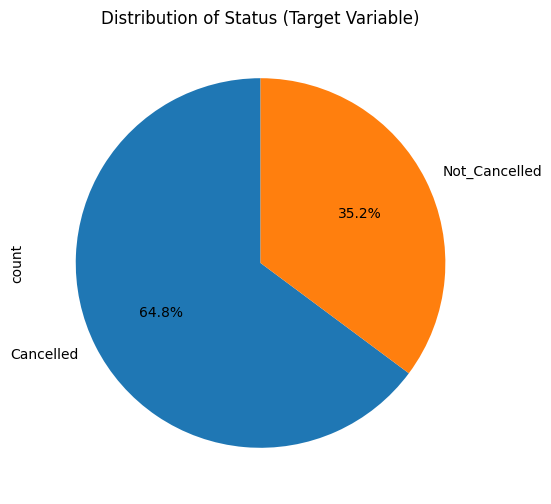

In [ ]:
status_counts = df['Status'].value_counts()

print("Status Counts: \n", status_counts)

# Plot a pie chart
status_counts.plot.pie(autopct='%1.1f%%', startangle=90, figsize=(6, 6))

# Add a title
plt.title('Distribution of Status (Target Variable)')

# Display the pie chart
plt.show()

Make Counts: 
 Make
CHEVROLET    253539
FORD         252136
NISSAN       140613
TOYOTA       140610
HONDA         92044
              ...  
EGIL              2
DAEW              1
237337            1
SPRINTER          1
TESLA             1
Name: count, Length: 91, dtype: int64


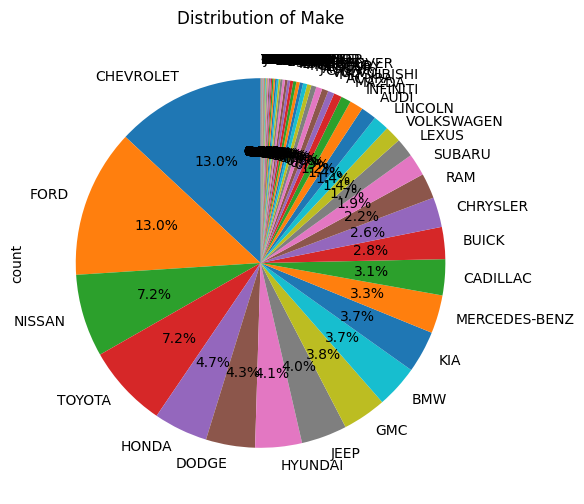

In [ ]:
make_counts = df['Make'].value_counts()

print("Make Counts: \n", make_counts)

# Plot a pie chart
make_counts.plot.pie(autopct='%1.1f%%', startangle=90, figsize=(6, 6))

# Add a title
plt.title('Distribution of Make')

# Display the pie chart
plt.show()

Model Counts: 
 Model_Category1
SILVERADO     55486
F150          52103
GRAND         42610
ESCAPE        36443
EQUINOX       35768
              ...  
BM840             1
J30               1
E400HYBRID        1
AEROSTAR          1
MIRAI             1
Name: count, Length: 1705, dtype: int64


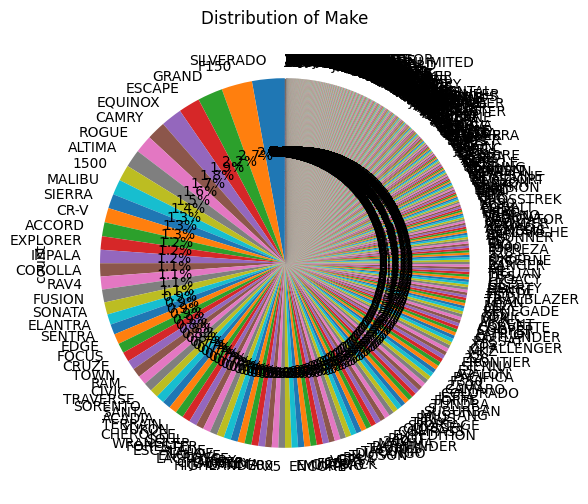

In [ ]:
model_counts = df['Model_Category1'].value_counts()

print("Model Counts: \n", model_counts)

# Plot a pie chart
model_counts.plot.pie(autopct='%1.1f%%', startangle=90, figsize=(6, 6))

# Add a title
plt.title('Distribution of Make')

# Display the pie chart
plt.show()

New and Used Counts: 
 New_Used
USED         1435122
NEW           430107
U              39686
N              32039
PROGRAM         3190
USEASNEW        2923
USEDASNEW          3
Name: count, dtype: int64


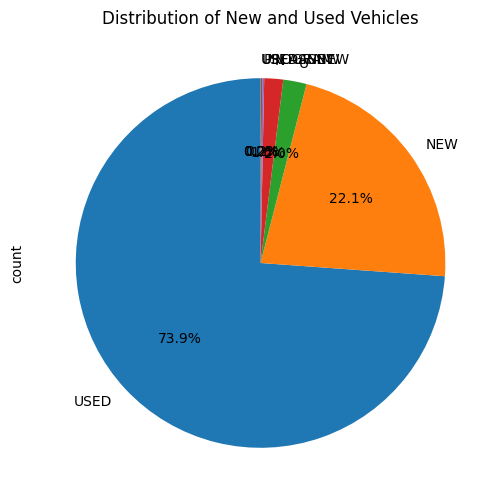

In [ ]:
new_used_counts = df['New_Used'].value_counts()

print("New and Used Counts: \n", new_used_counts)

# Plot a pie chart
new_used_counts.plot.pie(autopct='%1.1f%%', startangle=90, figsize=(6, 6))

# Add a title
plt.title('Distribution of New and Used Vehicles')

# Display the pie chart
plt.show()

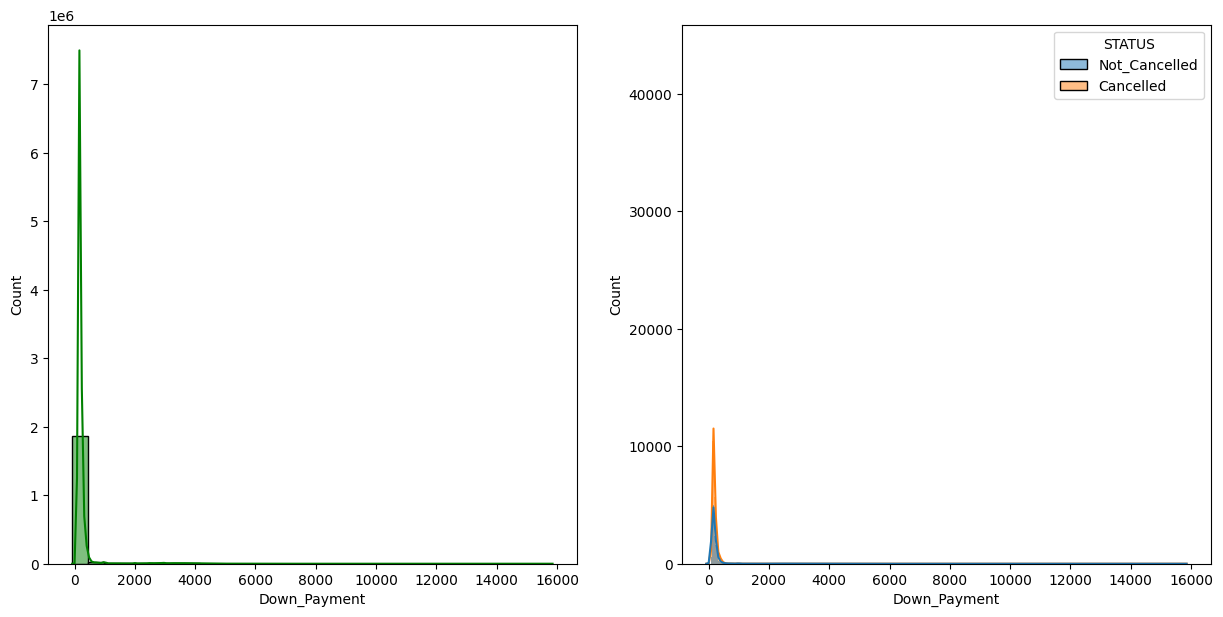

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
plt.subplot(121)
sns.histplot(data=df, x='Down_Payment', bins=30, kde=True, color='g')
plt.subplot(122)
sns.histplot(data=df, x='Down_Payment', kde=True, hue='Status')
plt.show()

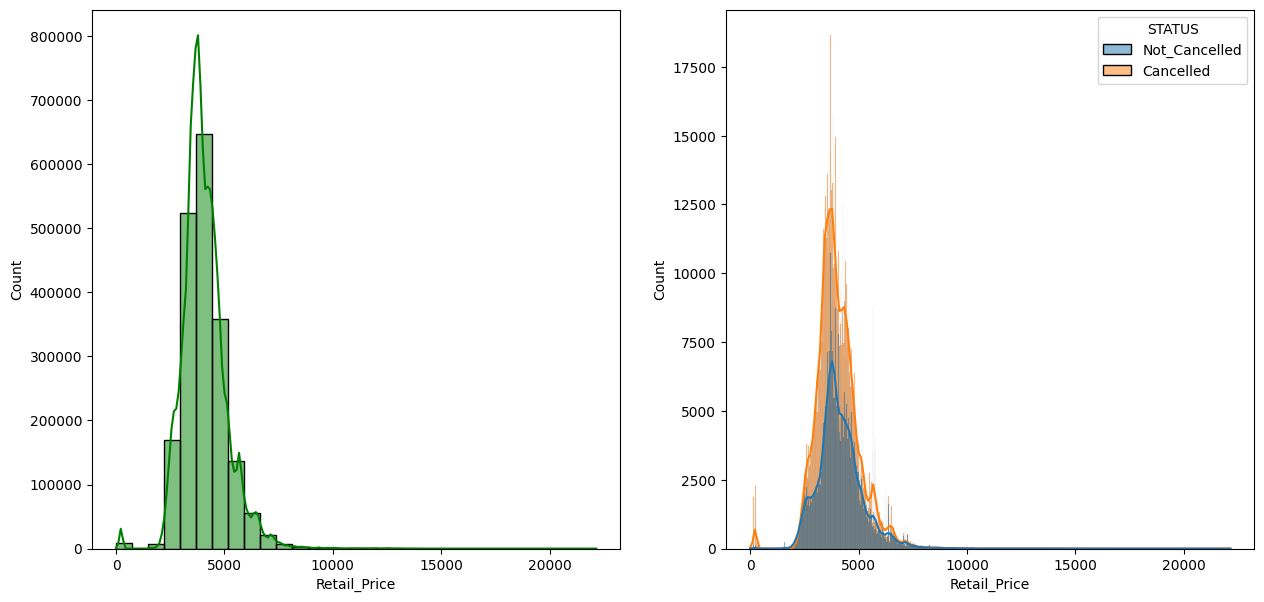

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
plt.subplot(121)
sns.histplot(data=df, x='Retail_Price', bins=30, kde=True, color='g')
plt.subplot(122)
sns.histplot(data=df, x='Retail_Price', kde=True, hue='Status')
plt.show()

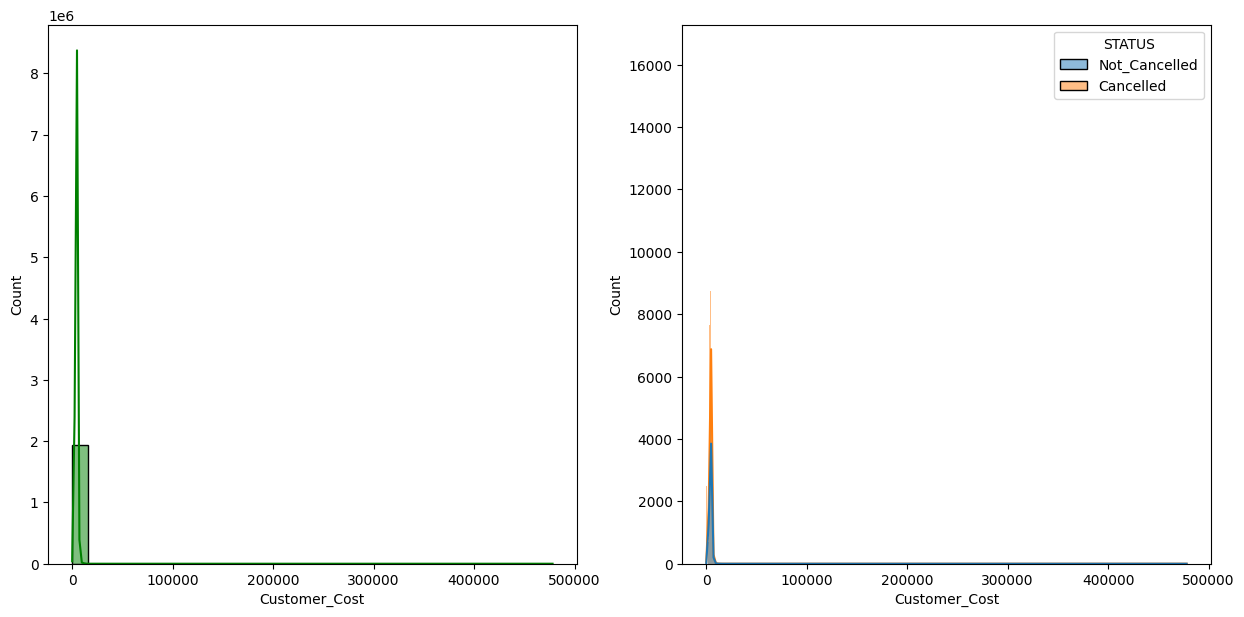

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
plt.subplot(121)
sns.histplot(data=df, x='Customer_Cost', bins=30, kde=True, color='g')
plt.subplot(122)
sns.histplot(data=df, x='Customer_Cost', kde=True, hue='Status')
plt.show()

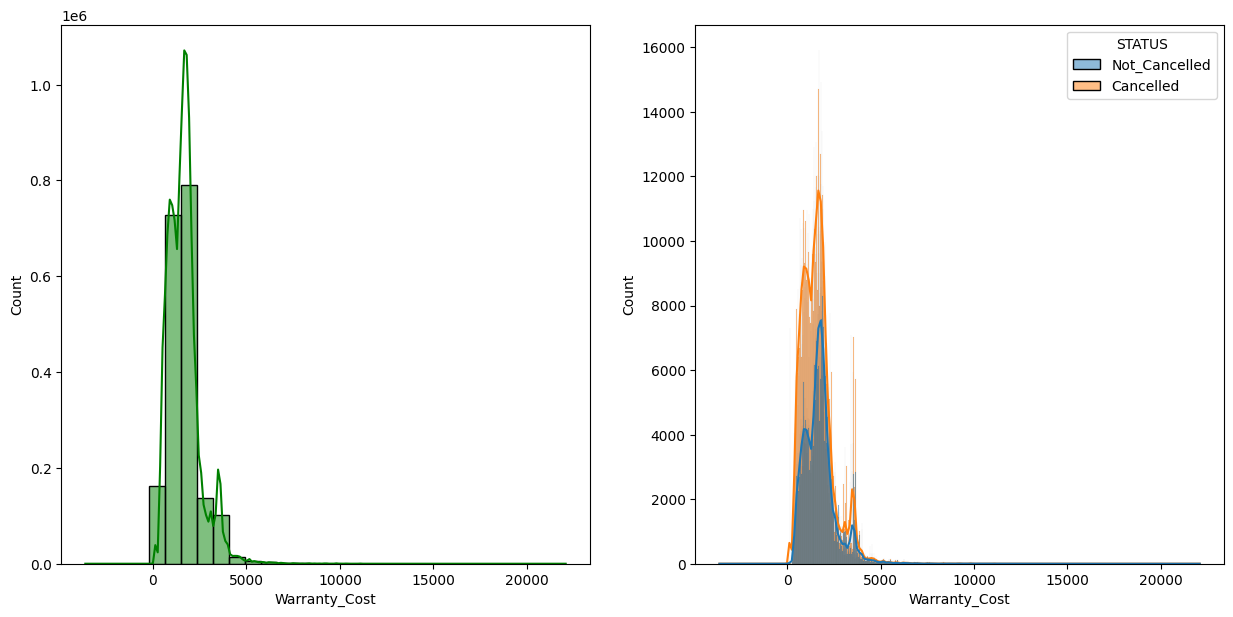

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
plt.subplot(121)
sns.histplot(data=df, x='Warranty_Cost', bins=30, kde=True, color='g')
plt.subplot(122)
sns.histplot(data=df, x='Warranty_Cost', kde=True, hue='Status')
plt.show()

### 6) Data Processing (for Modeling)
    - Filling missing data
    - LabelEncoding the Categorical Variables
    - Scaling the data (Central Limit Theorem)
    - Define the Features and Target Variable
    - Splitting the dataframe into 80/20

In [7]:
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [8]:
# Split into numerical and categorical columns
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()

In [ ]:
print("Numerical Columns: \n", numerical_columns)

Numerical Columns: 
 ['Duration', 'Term', 'Vehicle_Age', 'Mileage', 'Expiration_Miles', 'Finance_Term', 'Policy_Miles', 'Customer_Cost', 'Down_Payment', 'Finance_Payment', 'Retail_Price', 'Warranty_Cost']


In [ ]:
print("Categorical Columns: \n", categorical_columns)

Categorical Columns: 
 ['Contract_Number', 'Sale_Date', 'Cancel_Date', 'Make', 'Model', 'New_Used', 'Status', 'Model_Category1']


In [ ]:
print(len(numerical_columns), len(categorical_columns))

12 8


In [9]:
"""num_cols = ['Deductible', 
            'Term_Months', 
            'Term_Mileage', 
            'Model_Year',
            'Vehicle_Age', 
            'Sale_Odometer',
            'Effective_Odometer',  
            'Expire_Odometer',
            'Retail_Amount',
            'Admin_Cost',
            'Dealer_Cost', 
            'Base Reserve',
            'Claim Reserve', 
            'Insurance Fee',
            'Admin Fees', 
            'Gray Claim Fee'
    ]   
"""
num_cols = ['Duration', 
                #'Term',
                'Vehicle_Year',
                'Vehicle_Age',
                'Mileage',
                'Expiration_Miles',
                'Finance_Term',
                'Policy_Miles',
                'Customer_Cost',
                'Down_Payment',
                'Finance_Payment',
                'Retail_Price', 
                'Warranty_Cost'
                'Paid_In_Full',
                'Customer_Monthly_Payment',
]    

In [10]:
"""cat_cols = [#'Sales_Channel', 
            'Insurance_Type', 
            'Insurer_Code', 
            'Product_type_desc', 
            'Vehicle_Age',
            'Coverage_Group',
            'Deductible_Type',  
            'Customer_State',
            'New_Used',
            'GPW_NUP', 
            'Make',
            'Model_Category1', 
            'Vehicle_Class', 
            'Dealer_State', 
            'Status', 
    ]"""

cat_cols = [#'Contract_Number',
            'Term',
            'Make',
            'Model_Category1',
            'New_Used',
            'Status',
]

In [11]:
print(len(num_cols), len(cat_cols))

13 5


In [12]:
# columns to be dropped
"""drop_cols = ['Contract_Number', 
                'Contract_Id',
                'Dealer_Number',
                'Dealer_Name',
                'Dealer_Status', 
                'Inserted_Date',
                'Cancel_Effect_Date',
                'Effective_Date',
                'Sale_Date',
                'In_Service_Date',
                'OEMExpireDate',
                'Active_Date', 
                'Expiration_Date',
                'Coverage_Termination_Date',
        ]
"""
drop_cols = ['Contract_Number',
             'Sale_Date',
             'Cancel_Date',
        ]

#df = df.drop(drop_cols, axis=1)

In [13]:
""" INSERT FINAL DATAFRAME WITH PREDICTOR VARIABLES AND TARGET VARIABLE HERE """
"""
predictor_columns = [#'Sales_Channel',
                    'Insurance_Type',
                    'Insurer_Code',
                    'Product_type_desc',
                    'Coverage_Group',
                    'Deductible',
                    'Deductible_Type',
                    'Duration',
                    'Term_Months',
                    'Term_Mileage',
                    'Customer_State',
                    'New_Used',
                    'GPW_NUP',
                    'Make',
                    'Model_Category1',
                    'Model_Year',
                    'Vehicle_Age',
                    'Vehicle_Class',
                    'Sale_Odometer',
                    'Effective_Odometer',
                    'Expire_Odometer',
                    'Retail_Amount',
                    'Admin_Cost',
                    'Dealer_Cost',
                    'Base Reserve',
                    'Claim Reserve',
                    'Insurance Fee',
                    'Admin Fees',
                    'Gray Claim Fee',
                    'Dealer_State',
                    'Status',
]
"""
predictor_columns = [
        'Duration', 
        'Term',
        #'Vehicle_Year',
        'Vehicle_Age',
        'Mileage',
        'Expiration_Miles',
        'Finance_Term',
        'Policy_Miles',
        'Customer_Cost',
        'Down_Payment',
        'Finance_Payment',
        'Retail_Price', 
        'Warranty_Cost',
        'Make',
        'Model_Category1',
        'New_Used',
        'Paid_In_Full',
        'Customer_Monthly_Payment',
        'Status',
]

print(len(predictor_columns))

18


In [14]:
# Set the dataframe to only have the predictor columns
df = df[predictor_columns]

In [33]:
df.head()

,Duration,Term,Vehicle_Age,Mileage,Expiration_Miles,Finance_Term,Policy_Miles,Customer_Cost,Down_Payment,Finance_Payment,Retail_Price,Warranty_Cost,Make,Model_Category1,New_Used,Paid_In_Full,Customer_Monthly_Payment,Status
0,0.0,0.0,22.0,191978,251978,12,60000.0,3289.0,195.0,171.89,3289.0,939.0,CHEVROLET,SUBURBAN,N,NaN,NaN,Not_Cancelled
1,0.0,0.0,18.0,44371,92371,12,48000.0,3746.0,250.0,0.00,4428.0,2078.0,BMW,525,N,NaN,NaN,Not_Cancelled
2,0.0,0.0,16.0,29877,89877,12,60000.0,2993.0,195.0,0.00,3319.0,909.0,GMC,SIERRA,N,NaN,NaN,Not_Cancelled
3,0.0,0.0,17.0,83211,143211,12,60000.0,3895.0,205.0,0.00,4340.0,1565.0,BMW,X3,U,NaN,NaN,Not_Cancelled
4,0.0,48.0,22.0,40980,140980,18,100000.0,5875.0,1500.0,0.00,5875.0,3465.0,MERZ,MESL5,N,NaN,NaN,Cancelled


In [ ]:
df_evaluation = df[df['Status'] == 'Pending']

In [ ]:
df_evaluation.head()

,Insurance_Type,Insurer_Code,Product_type_desc,Coverage_Group,Deductible,Deductible_Type,Sale_Date,Duration,Term_Months,Term_Mileage,...,Retail_Amount,Admin_Cost,Dealer_Cost,Base Reserve,Claim Reserve,Insurance Fee,Admin Fees,Gray Claim Fee,Dealer_State,Status
91,XOL,WIC,VSC,DIRECTD,100.0,PerRepair,2020-05-11,57,60,100000,...,4280.0,643.0,643.0,295.0,295.0,31.00,317.0,15.0,MO,Pending
137,XOL,WIC,VSC,DIRECTD,100.0,PerRepair,2020-07-27,55,60,100000,...,3755.0,1056.0,1056.0,708.0,708.0,31.00,317.0,15.0,MO,Pending
206,XOL,WIC,VSC,DIRECTD,100.0,PerRepair,2020-06-25,56,72,125000,...,3117.0,510.0,510.0,162.0,162.0,31.00,317.0,15.0,MO,Pending
257,XOL,WIC,VSC,DIRECTD,100.0,PerRepair,2020-09-29,53,72,75000,...,3943.0,418.0,418.0,84.0,84.0,30.22,303.0,15.0,MO,Pending
281,XOL,WIC,VSC,DIRECTD,100.0,PerRepair,2020-10-12,52,72,125000,...,3975.0,496.0,496.0,162.0,162.0,30.22,303.0,15.0,MO,Pending


In [ ]:
# Drop rows where Status is "Pending" (since it is not a valid target). These should be the values that to be predicted in the future.
df = df[df['Status'] != 'Pending']

In [15]:
df = df.drop_duplicates()

In [16]:
df = df.dropna()

In [17]:
df_active = df[df['Status'] == 'Active']

In [18]:
df = df[df['Status'] != 'Active']

In [24]:
df.shape

(1219979, 18)

In [41]:
df.head(10)

,Duration,Term,Vehicle_Age,Mileage,Expiration_Miles,Finance_Term,Policy_Miles,Customer_Cost,Down_Payment,Finance_Payment,Retail_Price,Warranty_Cost,Make,Model_Category1,New_Used,Paid_In_Full,Customer_Monthly_Payment,Status
102053,60.0,60.0,12.0,82001,133001,36,50000.0,3627.0,180.00,95.75,3627.0,1627.0,BMW,528,USED,0.0,95.75,Not_Cancelled
102054,60.0,60.0,12.0,76000,152000,36,75000.0,4192.0,209.60,110.62,3992.0,2091.0,BMW,750,USED,0.0,110.62,Not_Cancelled
102056,5.0,72.0,15.0,99880,175880,36,75000.0,3503.0,175.15,92.44,3303.0,1303.0,LINCOLN,MKT,USED,0.0,92.44,Cancelled
102057,1.0,72.0,12.0,126650,202650,36,75000.0,3547.0,177.35,93.60,3447.0,1447.0,CHRYSLER,300,USED,0.0,93.60,Cancelled
102058,1.0,60.0,8.0,37916,101000,36,100000.0,2824.0,141.20,74.52,2924.0,992.0,CHEVROLET,CRUZE,NEW,0.0,149.04,Cancelled
102059,1.0,60.0,13.0,55003,106003,36,50000.0,2722.0,1361.00,37.81,3422.0,1422.0,BMW,528,USED,0.0,113.42,Cancelled
102060,60.0,60.0,14.0,119962,171462,36,50000.0,3381.0,169.05,89.22,3281.0,994.0,TOYOTA,PRIUS,USED,0.0,89.22,Not_Cancelled
102061,48.0,48.0,13.0,46091,89091,24,42000.0,4376.0,4376.00,0.00,4853.0,2921.0,PORSCHE,PANAMERA,USED,1.0,188.14,Not_Cancelled
102062,19.0,60.0,14.0,140116,191116,36,50000.0,3003.0,151.00,79.22,3103.0,1103.0,HYUNDAI,SANTA,USED,0.0,79.22,Cancelled
102065,60.0,60.0,9.0,44500,81000,36,80000.0,5070.0,1980.00,85.83,5270.0,3338.0,BMW,X5,NEW,0.0,85.36,Not_Cancelled


In [25]:
df['Status'].value_counts()

Status
Cancelled        1132562
Not_Cancelled      87417
Name: count, dtype: int64

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1219979 entries, 102053 to 1948370
Data columns (total 18 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   Duration                  1219979 non-null  float64
 1   Term                      1219979 non-null  float64
 2   Vehicle_Age               1219979 non-null  float64
 3   Mileage                   1219979 non-null  int64  
 4   Expiration_Miles          1219979 non-null  int64  
 5   Finance_Term              1219979 non-null  int64  
 6   Policy_Miles              1219979 non-null  float64
 7   Customer_Cost             1219979 non-null  float64
 8   Down_Payment              1219979 non-null  float64
 9   Finance_Payment           1219979 non-null  float64
 10  Retail_Price              1219979 non-null  float64
 11  Warranty_Cost             1219979 non-null  float64
 12  Make                      1219979 non-null  object 
 13  Model_Category1           1

In [44]:
categorical_columns_le = [#'Sales_Channel',
                          'Insurance_Type', 'Insurer_Code', 'Product_type_desc', 
                          'Coverage_Group', 'Deductible_Type',  
                          'Customer_State', 'New_Used', 'GPW_NUP', 
                          'Make', 'Model', 'Model_Category1', 
                          'Vehicle_Class', 
                          'Dealer_State', 
                          'Status', ]

#categorical_columns_le = ['Make', 'Model', 'State']

# Label Encoding for categorical variables
label_encoders = {}
for column in cat_cols:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

In [45]:
df.head()

,Duration,Term,Vehicle_Age,Mileage,Expiration_Miles,Finance_Term,Policy_Miles,Customer_Cost,Down_Payment,Finance_Payment,Retail_Price,Warranty_Cost,Make,Model_Category1,New_Used,Paid_In_Full,Customer_Monthly_Payment,Status
102053,60.0,6,12.0,82001,133001,36,50000.0,3627.0,180.00,95.75,3627.0,1627.0,6,85,5,0.0,95.75,1
102054,60.0,6,12.0,76000,152000,36,75000.0,4192.0,209.60,110.62,3992.0,2091.0,6,122,5,0.0,110.62,1
102056,5.0,7,15.0,99880,175880,36,75000.0,3503.0,175.15,92.44,3303.0,1303.0,39,810,5,0.0,92.44,0
102057,1.0,7,12.0,126650,202650,36,75000.0,3547.0,177.35,93.60,3447.0,1447.0,14,28,5,0.0,93.60,0
102058,1.0,6,8.0,37916,101000,36,100000.0,2824.0,141.20,74.52,2924.0,992.0,12,368,1,0.0,149.04,0


In [46]:
# Feature and Target Variables
X = df.drop('Status', axis=1)
y = df['Status']

In [47]:
""" 
Note: we use fit_transform() on the training data, but only transform() on the test data.
This is to avoid data leakage from the test set into the training set.
"""

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standard Scaling (for Logistic Regression and Neural Network)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Unsupervised Leaning 
- PCA
- SHAP
- dimenionality reduction techinique

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
""" We must sclaed the full X data for the dimensionality reduction techniques """
X_scaled = scaler.fit_transform(X)

In [ ]:
# Apply PCA
pca = PCA(n_components=12)  # Reduce to 2 dimensions
X_pca = pca.fit_transform(X_scaled)

### 7) Data Modeling
    - Spliting the dataframe 80/20
    - Applying Machine Learning Model (Unsupervised and Supervised Learning)
    - Model Evaluation (Confusion Matrix, Precision/Recall/F1-Score, AUC/ROC Curve, K-Fold Cross-Validation)
 

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso

In [ ]:
#pip install scikit-learn xgboost flaml lightgbm

In [49]:
""" USE FLAML LIBRARY TO FIND THE BEST MODEL """

from flaml import AutoML, tune

automl = AutoML()

# Specify automl goal and constraints
automl_settings = {
    "time_budget": 1_000,  # In seconds
    "metric": "accuracy",
    "task": "classification",
}

# fit classification on the training data
clf = automl.fit(X_train=X_train, y_train=y_train, **automl_settings)

# Export the best model
print(automl.model) 

[flaml.automl.logger: 03-25 13:16:21] {1728} INFO - task = classification
[flaml.automl.logger: 03-25 13:16:21] {1739} INFO - Evaluation method: holdout
[flaml.automl.logger: 03-25 13:16:22] {1838} INFO - Minimizing error metric: 1-accuracy
[flaml.automl.logger: 03-25 13:16:22] {1955} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'sgd', 'catboost', 'lrl1']
[flaml.automl.logger: 03-25 13:16:22] {2258} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 03-25 13:16:22] {2393} INFO - Estimated sufficient time budget=49213s. Estimated necessary time budget=1213s.
[flaml.automl.logger: 03-25 13:16:22] {2442} INFO -  at 2.4s,	estimator lgbm's best error=0.0715,	best estimator lgbm's best error=0.0715
[flaml.automl.logger: 03-25 13:16:22] {2258} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 03-25 13:16:22] {2442} INFO -  at 2.5s,	estimator lgbm's best error=0.0715,	best estimator lgbm's best error=0.0715
[flaml.

In [ ]:
""" MODEL PICKED FROM THE FLAML LIBRARY """

model_0 = 0


Saving the model into a pickle file

In [74]:

base_dir = 'C:\\Users\\RaymondGreenfield\\OneDrive - endurancedirect.com\\Documents\\Actuarial_Work\\src'
model_save_file = Path(base_dir) / 'Artifacts' / 'cancellation_model.pkl'


In [ ]:
# Save the model to a .pkl file
with open(model_save_file, 'wb') as f:
    pickle.dump(model_4, f)

print("Model saved as 'cancellation_model.pkl'")

### Toy Model for Testing Purposes

In [1]:
from flaml import AutoML
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
import pandas as pd

In [2]:
# Load regression dataset (California housing prices)
data = fetch_california_housing()

In [4]:
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

In [5]:
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [6]:
y

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

In [7]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
# Initialize FLAML AutoML for regression
automl = AutoML()

# Settings for regression
settings = {
    "time_budget": 60,  # time budget in seconds
    "metric": 'r2',    # can also use 'mae', 'mse', 'rmse'
    "task": 'regression',
    "verbose": 3,       # verbosity level
    "seed": 42,         # random seed
    "estimator_list": ['lgbm', 'rf', 'xgboost', 'catboost'],  # optional: specify estimators
}

# Train the model
automl.fit(X_train=X_train, y_train=y_train, **settings)

# Export the best model
print(automl.model) 

[flaml.automl.logger: 04-08 13:19:45] {1728} INFO - task = regression
[flaml.automl.logger: 04-08 13:19:45] {1739} INFO - Evaluation method: cv
[flaml.automl.logger: 04-08 13:19:45] {1838} INFO - Minimizing error metric: 1-r2
[flaml.automl.logger: 04-08 13:19:45] {1955} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'catboost']
[flaml.automl.logger: 04-08 13:19:45] {2258} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 04-08 13:19:45] {2393} INFO - Estimated sufficient time budget=1156s. Estimated necessary time budget=2s.
[flaml.automl.logger: 04-08 13:19:45] {2442} INFO -  at 0.1s,	estimator lgbm's best error=0.7333,	best estimator lgbm's best error=0.7333
[flaml.automl.logger: 04-08 13:19:45] {2258} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 04-08 13:19:45] {2442} INFO -  at 0.3s,	estimator lgbm's best error=0.7333,	best estimator lgbm's best error=0.7333
[flaml.automl.logger: 04-08 13:19:45] {2258} INFO - iteration 2, current 

In [16]:
# Print the best model found
print("\nBest model:", automl.model.estimator)
print("Best hyperparameter config:", automl.best_config)
print(f"Best R2 on validation data: {automl.best_loss:.4f}")

# Make predictions
y_pred = automl.predict(X_test)



Best model: <catboost.core.CatBoostRegressor object at 0x000002560735AA00>
Best hyperparameter config: {'early_stopping_rounds': 10, 'learning_rate': 0.09999999999999996, 'n_estimators': 8192}
Best R2 on validation data: 0.1603


In [17]:
# Evaluate on test data
from sklearn.metrics import r2_score, mean_squared_error
print(f"\nTest R2 score: {r2_score(y_test, y_pred):.4f}")
print(f"Test RMSE: {mean_squared_error(y_test, y_pred, squared=False):.4f}")

# You can also save the model
# automl.save("automl_regression_model.pkl")

# And later load it
# from flaml import AutoML
# automl = AutoML()
# automl.load("automl_regression_model.pkl")


Test R2 score: 0.8310
Test RMSE: 0.4706


c:\Users\RaymondGreenfield\miniconda3\envs\OnLevel\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
